In [1]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transform
import torch.utils.checkpoint as checkpoint
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
from tqdm import tqdm
train_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

In [2]:
train_images=[]
train_masks=[]
val_images=[]
val_masks=[]
def load_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.jpg'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=i[:,:256]
        msk=i[:,256:]  
        temp_img.append(img)
        temp_mask.append(msk) 
    return temp_img,temp_mask

train_images,train_masks=load_images(train_path)
val_images,val_masks=load_images(val_path)

100%|██████████| 500/500 [00:04<00:00, 114.86it/s]


In [3]:
class Model1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(self.pool(x1)))
        x3 = self.relu(self.conv3(self.pool(x2)))
        x4 = self.relu(self.conv4(self.pool(x3)))
        x5 = self.relu(self.conv5(self.pool(x4)))

        # Decoder
        x6 = self.upconv1(x5)
        x6 = self.relu(self.conv6(torch.cat([x6, x4], dim=1)))
        x7 = self.upconv2(x6)
        x7 = self.relu(self.conv7(torch.cat([x7, x3], dim=1)))
        x8 = self.upconv3(x7)
        x8 = self.relu(self.conv8(torch.cat([x8, x2], dim=1)))
        x9 = self.upconv4(x8)
        x9 = self.relu(self.conv9(torch.cat([x9, x1],dim=1)))
        x10 = self.conv10(x9)

        return self.softmax(x10)


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Model2(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        return out

In [5]:
model=Model1(3,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 70
batch_size = 32
train_batches = len(train_images)//batch_size
train_loss = []

In [6]:
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)

In [7]:
for epoch in range(num_epochs):
    print("Epoch : ", epoch+1 )
    for batch in tqdm(range(train_batches)):
        optimizer.zero_grad()
        train_img_batch = train_images[batch*batch_size:(batch+1)*batch_size]
        train_msk_batch = train_masks[batch*batch_size:(batch+1)*batch_size]
        #reshape images and masks
        img = np.reshape(train_img_batch, (len(train_img_batch), 3, 256, 256))
        mask = np.reshape(train_msk_batch, (len(train_msk_batch), 3, 256, 256))
        img = torch.from_numpy(img).float()
        mask = torch.from_numpy(mask).float()
        out = model(img.cuda())
        loss = criterion(out, mask.cuda())
        loss.backward()
        optimizer.step()
        t_loss = loss.item()
    print('Train Loss: ',t_loss)
torch.save(model.state_dict(), 'model1.pt')

Epoch :  1


100%|██████████| 92/92 [00:58<00:00,  1.59it/s]


Train Loss:  0.03793460130691528
Epoch :  2


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03619050979614258
Epoch :  3


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.0351688489317894
Epoch :  4


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03495847433805466
Epoch :  5


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03434959053993225
Epoch :  6


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03392694145441055
Epoch :  7


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.033352117985486984
Epoch :  8


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.033126771450042725
Epoch :  9


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.032884836196899414
Epoch :  10


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.032587796449661255
Epoch :  11


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.032119110226631165
Epoch :  12


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03191329911351204
Epoch :  13


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.031811997294425964
Epoch :  14


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03161804378032684
Epoch :  15


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03140384703874588
Epoch :  16


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.031442057341337204
Epoch :  17


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.031297095119953156
Epoch :  18


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03120310977101326
Epoch :  19


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.03115728124976158
Epoch :  20


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.031028728932142258
Epoch :  21


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.030913596972823143
Epoch :  22


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.030800973996520042
Epoch :  23


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.030567733570933342
Epoch :  24


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.030262282118201256
Epoch :  27


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.030154218897223473
Epoch :  28


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.0299488864839077
Epoch :  29


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02978108637034893
Epoch :  30


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02966463565826416
Epoch :  31


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02942526340484619
Epoch :  32


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02930888533592224
Epoch :  33


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.029337352141737938
Epoch :  34


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02902962826192379
Epoch :  35


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.0288461372256279
Epoch :  36


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02873249165713787
Epoch :  37


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028620194643735886
Epoch :  38


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02887260913848877
Epoch :  39


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028677210211753845
Epoch :  40


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02828206680715084
Epoch :  41


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028230084106326103
Epoch :  42


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02821822464466095
Epoch :  43


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028356928378343582
Epoch :  44


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028359239920973778
Epoch :  45


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.028427785262465477
Epoch :  46


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02818898856639862
Epoch :  47


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027729570865631104
Epoch :  48


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02766394428908825
Epoch :  49


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027375031262636185
Epoch :  50


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027134990319609642
Epoch :  51


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027072198688983917
Epoch :  52


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027078673243522644
Epoch :  53


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027066700160503387
Epoch :  54


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02718200348317623
Epoch :  55


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02717728167772293
Epoch :  56


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027162155136466026
Epoch :  57


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.027041438966989517
Epoch :  60


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.026535918936133385
Epoch :  61


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02643451653420925
Epoch :  62


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.026418127119541168
Epoch :  63


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02653779834508896
Epoch :  64


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02645755186676979
Epoch :  65


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.02619621530175209
Epoch :  66


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.026140784844756126
Epoch :  67


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.026221863925457
Epoch :  68


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.026164423674345016
Epoch :  69


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]


Train Loss:  0.025982890278100967
Epoch :  70


100%|██████████| 92/92 [00:54<00:00,  1.68it/s]

Train Loss:  0.025886129587888718


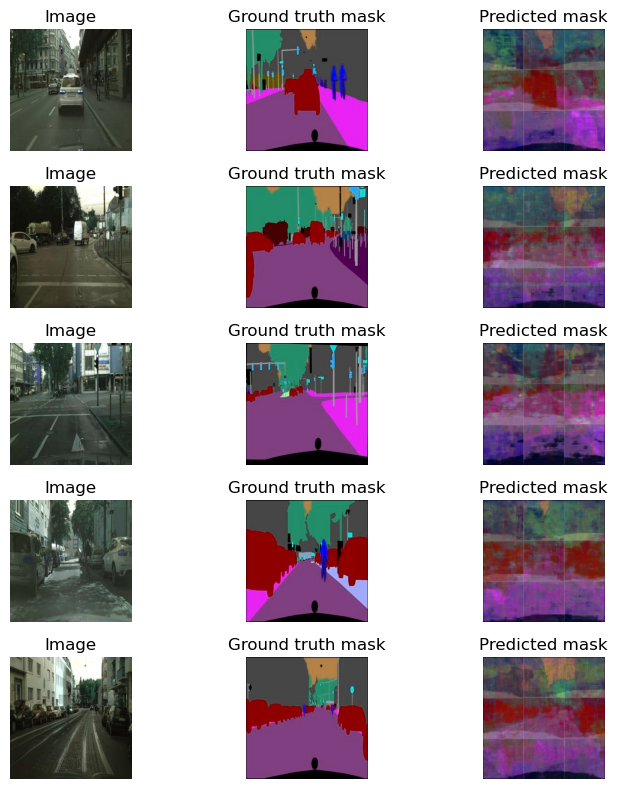

In [8]:
model_path = 'model1.pt'
device = torch.device('cuda')
model = model.to(device)
model.load_state_dict(torch.load(model_path))

img_ = train_images[10:15]
msk_ = train_masks[10:15]
w, h = 256, 256
col, row = 2, 2
img_batch = np.reshape(img_, (5, 3, 256, 256))
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(img_batch).cuda())
    predictions = predictions.cpu()

predictions = np.reshape(predictions, (5, 256, 256,3))
# Plot the images and predicted masks
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8, 8))
for i in range(5):
    axes[i, 0].imshow(img_[i])
    axes[i, 1].imshow(msk_[i])
    axes[i, 2].imshow(predictions[i])
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 0].set_title('Image')
    axes[i, 1].set_title('Ground truth mask')
    axes[i, 2].set_title('Predicted mask')
plt.tight_layout()
plt.show()


In [9]:
model=Model2(3,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 70
batch_size = 32
train_batches = len(train_images)//batch_size
train_loss = []

In [10]:
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)

In [11]:
for epoch in range(num_epochs):
    print("Epoch : ", epoch+1 )
    for batch in tqdm(range(train_batches)):
        optimizer.zero_grad()
        train_img_batch = train_images[batch*batch_size:(batch+1)*batch_size]
        train_msk_batch = train_masks[batch*batch_size:(batch+1)*batch_size]
        #reshape images and masks
        img = np.reshape(train_img_batch, (len(train_img_batch), 3, 256, 256))
        mask = np.reshape(train_msk_batch, (len(train_msk_batch), 3, 256, 256))
        img = torch.from_numpy(img).float()
        mask = torch.from_numpy(mask).float()
        out = model(img.cuda())
        loss = criterion(out, mask.cuda())
        loss.backward()
        optimizer.step()
        t_loss = loss.item()
    print('Train Loss: ',t_loss)
torch.save(model.state_dict(), 'model2.pt')

Epoch :  1


100%|██████████| 92/92 [01:15<00:00,  1.21it/s]


Train Loss:  0.032866038382053375
Epoch :  2


100%|██████████| 92/92 [01:14<00:00,  1.23it/s]


Train Loss:  0.029643632471561432
Epoch :  3


100%|██████████| 92/92 [01:14<00:00,  1.23it/s]


Train Loss:  0.028225000947713852
Epoch :  4


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.027143478393554688
Epoch :  5


100%|██████████| 92/92 [01:14<00:00,  1.23it/s]


Train Loss:  0.02611454576253891
Epoch :  6


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.02596440538764
Epoch :  7


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.025180695578455925
Epoch :  8


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.024939097464084625
Epoch :  9


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.024183399975299835
Epoch :  10


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.023970937356352806
Epoch :  11


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.02343330904841423
Epoch :  12


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.023080579936504364
Epoch :  13


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.022623112425208092
Epoch :  14


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.022585909813642502
Epoch :  15


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.022101348266005516
Epoch :  16


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.021639369428157806
Epoch :  17


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.02152096852660179
Epoch :  18


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.02113775536417961
Epoch :  19


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.02096770703792572
Epoch :  20


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.021012425422668457
Epoch :  21


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.020304355770349503
Epoch :  22


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019916394725441933
Epoch :  23


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019603170454502106
Epoch :  24


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019451666623353958
Epoch :  25


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019227037206292152
Epoch :  26


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019160302355885506
Epoch :  27


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.018785731866955757
Epoch :  28


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019006555899977684
Epoch :  29


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01894931122660637
Epoch :  30


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.018389374017715454
Epoch :  31


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01834098808467388
Epoch :  32


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01811523549258709
Epoch :  33


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.017920060083270073
Epoch :  34


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.019169555976986885
Epoch :  35


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01818091981112957
Epoch :  36


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.017266815528273582
Epoch :  37


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01692875288426876
Epoch :  38


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01669052615761757
Epoch :  39


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.016752218827605247
Epoch :  40


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.016252141445875168
Epoch :  41


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01620582677423954
Epoch :  42


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015970665961503983
Epoch :  43


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015966273844242096
Epoch :  44


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015597420744597912
Epoch :  45


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015341749414801598
Epoch :  46


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01541086845099926
Epoch :  47


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015347782522439957
Epoch :  48


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.015032689087092876
Epoch :  49


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01502737682312727
Epoch :  50


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.014630135148763657
Epoch :  51


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.014241404831409454
Epoch :  52


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.014109902083873749
Epoch :  53


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.014050579629838467
Epoch :  54


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01388581097126007
Epoch :  55


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.013606983236968517
Epoch :  56


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.013510427437722683
Epoch :  57


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.013190041296184063
Epoch :  58


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.012945672497153282
Epoch :  59


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.012576466426253319
Epoch :  60


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.012165768072009087
Epoch :  61


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.016381390392780304
Epoch :  62


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.013779832050204277
Epoch :  63


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.012512984685599804
Epoch :  64


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.011813491582870483
Epoch :  65


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.011542054824531078
Epoch :  66


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.011245755478739738
Epoch :  67


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.011214885860681534
Epoch :  68


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.010843816213309765
Epoch :  69


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]


Train Loss:  0.01067567802965641
Epoch :  70


100%|██████████| 92/92 [01:15<00:00,  1.23it/s]

Train Loss:  0.010362939909100533


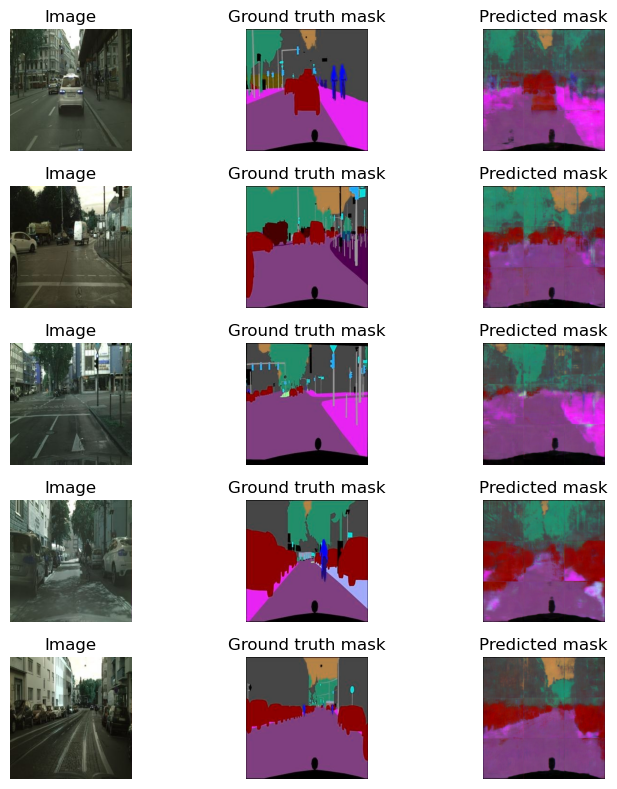

In [12]:
model_path = 'model2.pt'
device = torch.device('cuda')
model = model.to(device)
model.load_state_dict(torch.load(model_path))

img_ = train_images[10:15]
msk_ = train_masks[10:15]
w, h = 256, 256
col, row = 2, 2
img_batch = np.reshape(img_, (5, 3, 256, 256))
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(img_batch).cuda())
    predictions = predictions.cpu()

predictions = np.reshape(predictions, (5, 256, 256,3))
# Plot the images and predicted masks
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8, 8))
for i in range(5):
    axes[i, 0].imshow(img_[i])
    axes[i, 1].imshow(msk_[i])
    axes[i, 2].imshow(predictions[i])
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 0].set_title('Image')
    axes[i, 1].set_title('Ground truth mask')
    axes[i, 2].set_title('Predicted mask')
plt.tight_layout()
plt.show()
